Data preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__) # 1.4.1
import network, train, utils
from layers import SigmoidLayer, ReluLayer, TanhLayer, SoftPlusLayer, TernaryFullyConnectedLayer, BatchNormLayer
import os

import distutils
''' compatible with 1.15
if distutils.version.LooseVersion(tf.__version__) <= '2.0':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')
'''

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)

1.15.2


In [ ]:
images = np.concatenate([x_train, x_test], axis=0)
labels = np.concatenate([y_train, y_test], axis=0)

n_train, n_valid, n_test = 55000, 5000, 10000

images = images.reshape(70000, 784)
y_labels = np.zeros((70000,10), dtype=int)

for i in range(70000):
  y_labels[i][labels[i]] = 1

x_train = images[:n_train]
y_train = y_labels[:n_train]
x_validate = images[n_train:n_train+n_valid]
y_validate = y_labels[n_train:n_train+n_valid]
x_test = images[-n_test:]
y_test = y_labels[-n_test:]

Neural Network Structure

In [ ]:
nn = network.NeuralNetwork(in_size=[None, 784], n_out_classes=10, loss_func=utils.smooth_hinge_loss)

nn.reset_graph()

# Hidden FC-1
nn.add_layer(TernaryFullyConnectedLayer(out_dim=2048))
nn.add_layer(BatchNormLayer(axes=[0]))
nn.add_layer(SoftplusLayer())

# Hidden FC-2
nn.add_layer(TernaryFullyConnectedLayer(out_dim=2048))
nn.add_layer(BatchNormLayer(axes=[0]))
nn.add_layer(SoftplusLayer())

# Hidden FC-3
nn.add_layer(TernaryFullyConnectedLayer(out_dim=2048))
nn.add_layer(BatchNormLayer(axes=[0]))
nn.add_layer(SoftplusLayer())

# Output SVM layer (linear part)
nn.add_layer(TernaryFullyConnectedLayer(out_dim=10))
nn.add_layer(BatchNormLayer(axes=[0]))

nn.finalize()

Initiation

In [ ]:
data_train = (x_train, y_train)
opt = train.Trainer(nn, data_train)

opt.set_rho(0.5)
opt.set_ema_rates(0.999)

Training

In [ ]:
losses_and_accs_train = []
losses_and_accs_valid = []
losses_and_accs_test = []
sparsity_fracs = []

n_epochs = 100

for t in range(n_epochs):
    print('Epoch: ', t)
    opt.train_epoch(batch_size=100, ema_decay=0.95, n_output=10, verbose=True)
    
    losses_and_accs_train.append(
        opt.loss_and_accuracy((x_train, y_train), max_batch=400, inference=True))
    losses_and_accs_test.append(
        opt.loss_and_accuracy((x_test, y_test), max_batch=400, inference=True))
    losses_and_accs_valid.append(
        opt.loss_and_accuracy((x_validate, y_validate), max_batch=400, inference=True))
    sparsity_fracs.append(utils.get_sparsity_frac(nn, opt))

    print('Train loss/acc: ', losses_and_accs_train[-1],
          'Test loss/acc: ', losses_and_accs_test[-1])

losses_and_accs_train = np.asarray(losses_and_accs_train)
losses_and_accs_valid = np.asarray(losses_and_accs_valid)
losses_and_accs_test = np.asarray(losses_and_accs_test)
sparsity_fracs = np.asarray(sparsity_fracs)

Epoch:  0
========= Begin epoch =========
batch_size = 100
EMA rates:
[0.999, 0.999, 0.999, 0.999]
rho:
[0.5, 0.5, 0.5, 0.5]
Iter: 0 of 550 || Estimated train loss/acc: 1.201993, 0.45
Iter: 55 of 550 || Estimated train loss/acc: 0.893175, 0.74
Iter: 110 of 550 || Estimated train loss/acc: 0.794007, 0.69
Iter: 165 of 550 || Estimated train loss/acc: 0.757418, 0.70
Iter: 220 of 550 || Estimated train loss/acc: 0.658218, 0.71
Iter: 275 of 550 || Estimated train loss/acc: 0.616286, 0.78
Iter: 330 of 550 || Estimated train loss/acc: 0.494251, 0.80
Iter: 385 of 550 || Estimated train loss/acc: 0.444862, 0.86
Iter: 440 of 550 || Estimated train loss/acc: 0.419389, 0.82
Iter: 495 of 550 || Estimated train loss/acc: 0.373392, 0.79
Sparsity fraction (ratio of non-zero weights):  0.8491420388972685
Train loss/acc:  (0.3251860919865695, 0.84225454677235) Test loss/acc:  (0.33525983572006224, 0.8271999955177307)
Epoch:  1
========= Begin epoch =========
batch_size = 100
EMA rates:
[0.99905, 0.99905

Results

In [ ]:
print('Train: ', opt.loss_and_accuracy((x_train, y_train), inference=True))
print('Valid: ', opt.loss_and_accuracy((x_validate, y_validate), inference=True))
print('Test: ', opt.loss_and_accuracy((x_test, y_test), inference=True))

Train:  (4.714051142813829e-06, 1.0)
Valid:  (0.21938569843769073, 0.8999999761581421)
Test:  (0.23673656582832336, 0.8935999870300293)


In [ ]:
best_epoch = np.argmax(losses_and_accs_valid[:,5]) + 1
print('Best epoch: ', best_epoch)
print('Train acc: ', losses_and_accs_train[best_epoch-1, 1])
print('Valid acc: ', losses_and_accs_valid[best_epoch-1, 1])
print('Test acc: ', losses_and_accs_test[best_epoch-1, 1])

Best epoch:  97
Train acc:  1.0
Valid acc:  0.900599992275238
Test acc:  0.8969999980926514


Final results:  [4.71405103e-06 1.00000000e+00 2.19385690e-01 8.99999993e-01
 2.36736570e-01 8.93599992e-01]


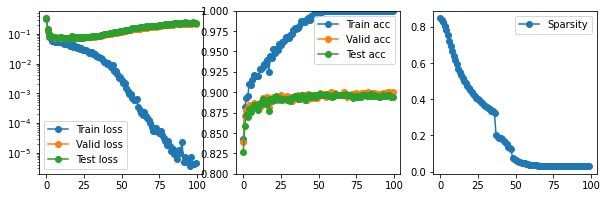

In [ ]:
losses_and_accs = np.concatenate(
    [np.asarray(losses_and_accs_train),
     np.asarray(losses_and_accs_valid),
     np.asarray(losses_and_accs_test)], axis=1)

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.semilogy(losses_and_accs[:,0], '-o', label='Train loss')
ax1.semilogy(losses_and_accs[:,2], '-o', label='Valid loss')
ax1.semilogy(losses_and_accs[:,4], '-o', label='Test loss')

ax2.plot(losses_and_accs[:,1], '-o', label='Train acc')
ax2.plot(losses_and_accs[:,3], '-o', label='Valid acc')
ax2.plot(losses_and_accs[:,5], '-o', label='Test acc')

ax3.plot(sparsity_fracs, '-o', label='Sparsity')

for ax in [ax1,ax2,ax3]:
    ax.legend()

ax2.set_ylim(0.8,1)
    
print('Final results: ', losses_and_accs[-1])

save variables

In [ ]:
# Train loss
# Train acc
# Valid loss
# Valid acc
# Test loss
# Test acc
# Sparsity
df = pd.DataFrame({"Train loss": losses_and_accs[:,0],
           "Train acc": losses_and_accs[:,1],
           "Valid loss": losses_and_accs[:,2],
           "Valid acc": losses_and_accs[:,3],
           "Test loss": losses_and_accs[:,4],
           "Test acc": losses_and_accs[:,5],
           "Sparsity": sparsity_fracs})
df.to_csv("ternary_3hidden_softplus_l2.csv")